In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import MatlabRandn
from numpy.random import randn
from scipy.optimize import curve_fit

In [3]:
randn = MatlabRandn()

# bpath2.m

In [5]:
def reset_seed():
    try:
        randn.reset()
        print("Using Matlab Random Numbers")
    except AttributeError:
        np.random.seed(100)
        print("Using numpy Random Numbers")

Using Matlab Random Numbers


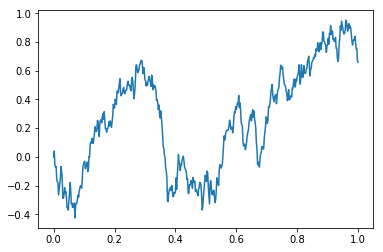

In [6]:
reset_seed()
T = 1
N = 500
dt = T/N
dW = np.sqrt(dt)*randn(N)
dW = np.insert(dW, 0, 0)
W = np.cumsum(dW)
t = np.arange(0, T+dt, dt)
plt.plot(t, W)

# bpath3.m

Using Matlab Random Numbers


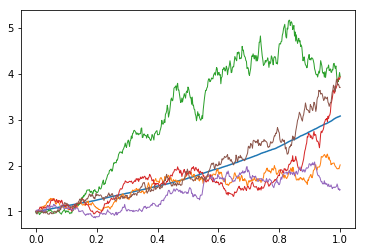

In [93]:
reset_seed()
T = 1
N = 500
M = 1000
dt = T/N
t = np.arange(0, T+dt, dt)
dW_0 = np.zeros((M, 1))
dW = np.hstack([dW_0, np.sqrt(dt)*randn(M, N)])
W = np.cumsum(dW, axis=1)
U = np.exp(np.tile(t, (M, 1)) + 0.5*W)
Umean = np.mean(U, axis=0)
plt.plot(t, Umean)
plt.plot(np.tile(t, (5, 1)).T, U[:5,].T, linewidth=1)

# stint.m

In [8]:
reset_seed()
T = 1
N = 500
dt = T/N
dW = np.sqrt(dt)*randn(N)
dW = np.insert(dW, 0, 0)
W = np.cumsum(dW)

ito = np.sum(W[:-1]*dW[1:])
itoerr = np.abs(ito - 0.5*(W[-1]**2 - T))

strat = np.sum((0.5*(W[:-1]+W[1:]) + 0.5*np.sqrt(dt)*randn(N)) * dW[1:])
straterr = np.abs(strat - 0.5*W[-1]**2)
ito, itoerr, strat, straterr

Using Matlab Random Numbers


(-0.26741580522560493,
 0.01575948446232145,
 0.2353871713525124,
 0.018562461040438794)

# em.m

Using Matlab Random Numbers
Wall time: 27.9 ms


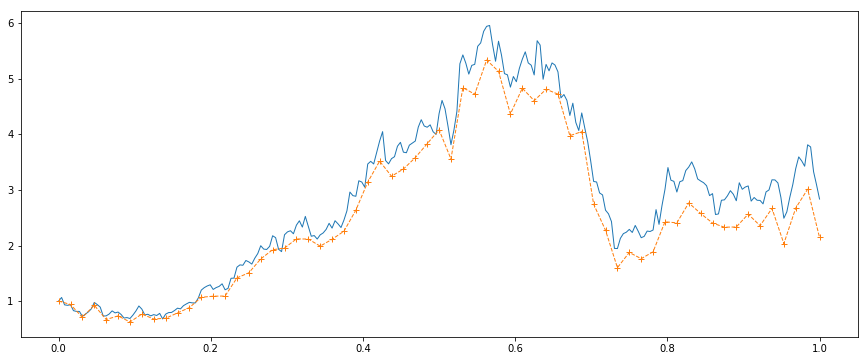

In [6]:
%%time
reset_seed()
plt.figure(figsize=(15,6))
lamda = 2
mu = 1
X_0 = 1
T = 1
N = 2**8
dt = T/N
dW = np.sqrt(dt)*randn(N)
dW = np.insert(dW, 0, 0)
W = np.cumsum(dW)
t = np.arange(0, T+dt, dt)

X_true = X_0 * np.exp((lamda-0.5*mu**2)*t + mu*W)
plt.plot(t, X_true, linewidth=1)

R = 4
Dt = R*dt
L = int(N/R)
X_em = np.zeros(L+1)
X_temp = X_0
X_em[0] = X_0
for j in range(1, L+1):
    Winc = np.sum(dW[R*(j-1)+1:R*j+1])
    X_temp = X_temp + Dt*lamda*X_temp + mu*X_temp*Winc
    X_em[j] = X_temp
plt.plot(np.arange(0, T+Dt, Dt), X_em, "+--", linewidth=1)

In [113]:
X_true[-1] - X_em[-1]

0.6907476291643118

In [9]:
def brownian_path(T, N):
    dt = T/N
    dW = np.sqrt(dt)*randn(N)
    dW = np.insert(dW, 0, 0)
    W = np.cumsum(dW)
    t = np.arange(0, T+dt, dt)
    return t, W

In [10]:
def solve_em(f, g, X_0, t, W):
    X_em = np.zeros(len(W))
    X_temp = X_0
    X_em[0] = X_0
    for j in range(1, len(W)):
        W_inc = W[j] - W[j-1]
        dt = t[j] - t[j-1]
        X_temp = X_temp + dt*f(X_temp) + g(X_temp)*W_inc
        X_em[j] = X_temp
    return t, X_em

In [11]:
def solve_milstein(f, g, g_deriv, X_0, t, W):
    X_em = np.zeros(len(W))
    X_temp = X_0
    X_em[0] = X_0
    for j in range(1, len(W)):
        W_inc = W[j] - W[j-1]

        dt = t[j] - t[j-1]
        X_temp = X_temp \
                 + dt*f(X_temp) \
                 + g(X_temp) * W_inc \
                 + 0.5 * g(X_temp) * g_deriv(X_temp) * (W_inc**2 - dt)
        X_em[j] = X_temp
    return t, X_em

Using Matlab Random Numbers
Wall time: 18 ms


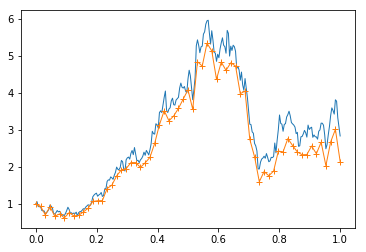

In [12]:
%%time
reset_seed()

lamda = 2
X_0 = 1
mu = 1
f = lambda x: lamda * x
g = lambda x: mu * x

t, W = brownian_path(1, 2**8)
X_true = X_0 * np.exp((lamda-0.5*mu**2)*t + mu*W)
t_em, X_em = solve_em(f, g, X_0, t[::4], W[::4])

plt.plot(t, X_true, linewidth=1)
plt.plot(t_em, X_em, "+-", linewidth=1)

# emstrong.m

Using Matlab Random Numbers


(0.001, 0.1)

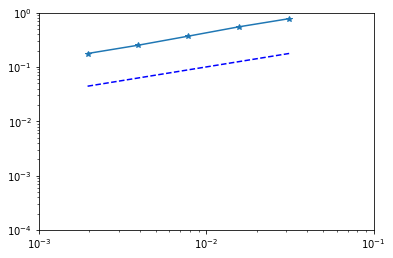

In [144]:
reset_seed()

lamda = 2
X_0 = 1
mu = 1
f = lambda x: lamda * x
g = lambda x: mu * x

dt = 2**(-9)
T = 1
M = 1000
N = int(T/dt)

X_err = np.zeros((M, 5))

#t = np.arange(0, T+dt, dt)
#dW_0 = np.zeros((M, 1))
#dW = np.hstack([dW_0, np.sqrt(dt)*randn(M, N)])
#Ws = np.cumsum(dW, axis=1)

for path in range(M):
    t, W = brownian_path(T=T, N=int(T/dt))
    #W = Ws[path]
    X_true = X_0 * np.exp((lamda-0.5*mu**2)*t + mu*W)
    for p in range(5):
        t_em, X_em = solve_em(f, g, X_0, t[::2**p], W[::2**p])
        endpoint_error = np.abs(X_em[-1] - X_true[-1])
        X_err[path, p] = endpoint_error
        
dt_vals = 2**np.arange(5) * 2**(-9)

plt.loglog(dt_vals, np.mean(X_err, axis=0), "*-")
plt.loglog(dt_vals, dt_vals**0.5, "b--")

plt.ylim(10**(-4), 1)
plt.xlim(10**(-3), 10**(-1))        

In [148]:
stats.linregress(np.log(dt_vals),np.log(np.mean(X_err, axis=0)))

LinregressResult(slope=0.5383664717975093, intercept=1.6161069241740602, rvalue=0.999745266563053, pvalue=4.880296354941735e-06, stderr=0.007017110857738456)

# milstrong

Using Matlab Random Numbers


(0.001, 0.1)

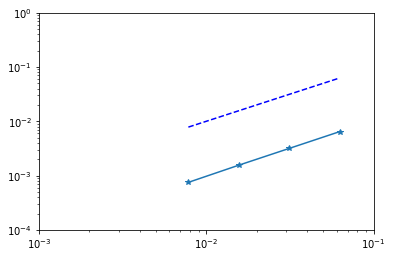

In [32]:
reset_seed()

r = 2
K = 1
beta = 0.25
X_0 = 0.5

f = lambda x: r*x*(K-x)
g = lambda x: beta*x
g_deriv = lambda x: beta

dt = 2**(-11)
T = 1
M = 500
N = int(T/dt)

X_err = np.zeros((M, 4))

t = np.arange(0, T+dt, dt)
dW_0 = np.zeros((M, 1))
dW = np.hstack([dW_0, np.sqrt(dt)*randn(M, N)])
Ws = np.cumsum(dW, axis=1)

for path in range(M):
    #t, W = brownian_path(T=T, N=int(T/dt))
    W = Ws[path]
    X_true = solve_milstein(f, g, g_deriv, X_0, t, W)[1]
    for i, p in enumerate(range(4, 8)):
        t_em, X_em = solve_milstein(f, g, g_deriv, X_0, t[::2**p], W[::2**p])
        endpoint_error = np.abs(X_em[-1] - X_true[-1])
        X_err[path, i] = endpoint_error
        
dt_vals = 2**np.arange(4,8) * dt

plt.loglog(dt_vals, np.mean(X_err, axis=0), "*-")
plt.loglog(dt_vals, dt_vals, "b--")

plt.ylim(10**(-4), 1)
plt.xlim(10**(-3), 10**(-1))      

In [33]:
import scipy.stats as stats
stats.linregress(np.log(dt_vals),np.log(np.mean(X_err, axis=0)))

LinregressResult(slope=1.0315778833566316, intercept=-2.1819670135074842, rvalue=0.9999822137952978, pvalue=1.7786204702163754e-05, stderr=0.004350603040377452)

# Implicit Method

Using Matlab Random Numbers


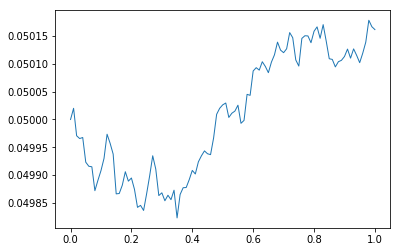

In [149]:
reset_seed()
T = 1
N = 100
dt = T/N
dW = np.sqrt(dt)*randn(N)
dW = np.insert(dW, 0, 0)
W = np.cumsum(dW)

k = 1
lamda = 0.05
theta = 2*k*lamda * 0.01
assert 2*k*lamda > theta**2
alpha = (4*k*lamda - theta**2)/8
beta = -k/2
gamma = theta/2

Y_implicit = np.zeros(N+1)


X_0 = lamda
Y_temp = np.sqrt(X_0)
Y_implicit[0] = np.sqrt(X_0)
for k in range(1, N+1):
    W_inc = dW[k]
    Y_temp = (Y_temp + gamma*dW[k])/(2*(1-beta*dt)) \
             + np.sqrt(
                 (Y_temp + gamma*dW[k])**2/(4*(1-beta*dt)**2) \
                 + (alpha*dt)/(1-beta*dt)
             )
    Y_implicit[k] = Y_temp
X_implicit = Y_implicit**2
plt.plot(np.arange(0, T+dt, dt), X_implicit, linewidth=1)

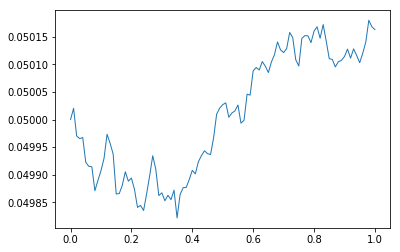

In [18]:
k = 1
lamda = 0.05
theta = 2*k*lamda * 0.01

f = lambda x: k * (lamda - x)
g = lambda x: theta * np.sqrt(x)

em = solve_em(f, g, lamda, t, W)
plt.plot(t, em, linewidth=1)